<a href="https://colab.research.google.com/github/mehang/Improvised-CNN/blob/master/notebook/Caltech-256-128/resized/15*15/caltech256_15_15_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
!unzip /content/drive/My\ Drive/Mehang\ Rai/caltech-256-image-128.zip -d caltech-256-image-128

Streaming output truncated to the last 5000 lines.
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0001.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0248.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0644.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0768.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0404.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0303.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0109.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0122.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0745.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0043.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0325.jpg  
  i

In [4]:
ITERATION = 2
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
RANDOM_SEED = [42,42,34,56,62,74,29,15,7,81][ITERATION-1]
BATCH_SIZE = 32
NUM_CLASSES = 257
EPOCHS = 1000
GABOR_LAYER_INDEX = 0
GABOR_WIDTH = 15
GABOR_HEIGHT = 15
GABOR_SIZE = (GABOR_WIDTH, GABOR_HEIGHT)
NUM_RECEPTIVE_FILTERS = 32
DATA_DIRECTORY = "caltech-256-image-128/caltech-256-image-128/"

In [5]:
filenames = os.listdir(DATA_DIRECTORY)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=RANDOM_SEED)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [7]:
print(train_df.shape)
print(validate_df.shape)

(24485, 2)
(6122, 2)


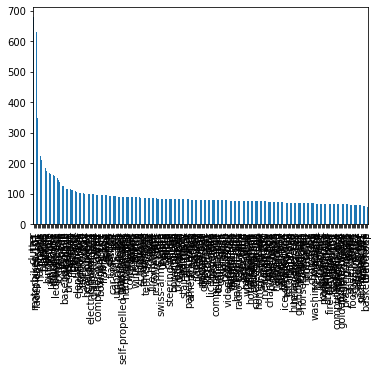

In [8]:
train_df['category'].value_counts().plot.bar()

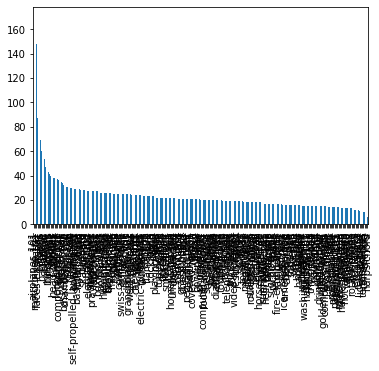

In [9]:
validate_df['category'].value_counts().plot.bar()

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # fill_mode='nearest',
    rescale=1./255,
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    DATA_DIRECTORY, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 24485 validated image filenames belonging to 257 classes.


In [11]:
validation_datagen = ImageDataGenerator(
    # fill_mode='nearest',
    rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    DATA_DIRECTORY, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 6122 validated image filenames belonging to 257 classes.


In [12]:
train_generator.image_shape

(128, 128, 3)

In [13]:
NUM_CLASSES = len(train_df['category'].value_counts())
print(NUM_CLASSES)

257


In [14]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

classifier = None
classifier = Sequential([
    layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), 
                  padding='same', name="GaborLayer", input_shape=train_generator.image_shape),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.1),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.1),
    layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.1),
    layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.1),
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

classifier.summary()

import copy
untrained_layers = copy.deepcopy(classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GaborLayer (Conv2D)          (None, 128, 128, 32)      21632     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
765/765 [==============================] - 135s 169ms/step - loss: 5.4182 - accuracy: 0.0545 - auc: 0.6250 - val_loss: 7.1915 - val_accuracy: 0.0697 - val_auc: 0.6211
Epoch 2/1000
765/765 [==============================] - 126s 165ms/step - loss: 4.8172 - accuracy: 0.0967 - auc: 0.7261 - val_loss: 6.1982 - val_accuracy: 0.0707 - val_auc: 0.6245
Epoch 3/1000
765/765 [==============================] - 125s 164ms/step - loss: 4.5434 - accuracy: 0.1177 - auc: 0.7708 - val_loss: 4.7453 - val_accuracy: 0.1266 - val_auc: 0.7526
Epoch 4/1000
765/765 [==============================] - 124s 163ms/step - loss: 4.3174 - accuracy: 0.1445 - auc: 0.7999 - val_loss: 4.2915 - val_accuracy: 0.1590 - val_auc: 0.7966
Epoch 5/1000
765/765 [==============================] - 123s 161ms/step - loss: 4.0978 - accuracy: 0.1675 - auc: 0.8217 - val_loss: 4.4396 - val_accuracy: 0.1422 - val_auc: 0.7797
Epoch 6/1000
765/765 [==============================] - 123s 161ms/step - loss: 3.9664 - accuracy: 0

In [16]:
classifier.layers[GABOR_LAYER_INDEX].name

'GaborLayer'

In [17]:
print("Start time = {}".format(start))
print("Finish time = {}".format(finish))
print("Training time = {}".format(finish-start))
hist.history['start_time'] = start
hist.history['finish_time'] = finish
hist.history['train_time'] = finish-start

Start time = 629.604260392
Finish time = 9997.956791468
Training time = 9368.352531076


In [18]:
import pickle

trained_layers = copy.deepcopy(classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights())
hist.history['untrained_layers'] = untrained_layers
hist.history['trained_layers'] = trained_layers

with open('caltech256-{}-history-kernel-{}.p'.format(ITERATION, GABOR_WIDTH),'wb') as fp:
    pickle.dump(hist.history, fp, protocol=pickle.HIGHEST_PROTOCOL)

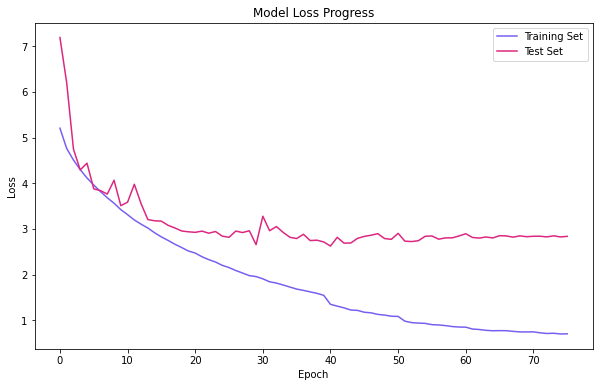

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('caltech256-{}-loss-kernel-{}.png'.format(ITERATION,GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

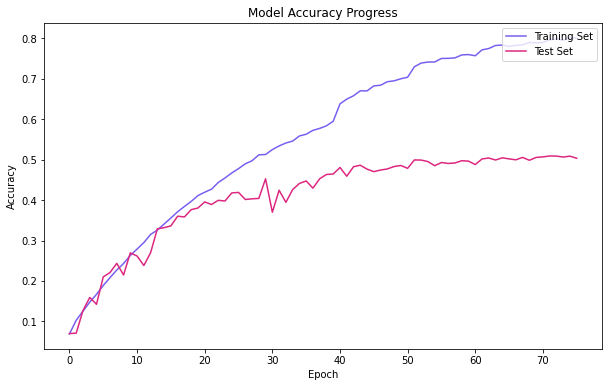

In [20]:
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], color='#785ef0')
plt.plot(hist.history['val_accuracy'], color='#dc267f')
plt.title('Model Accuracy Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('caltech256-{}-accuracy-kernel-{}.png'.format(ITERATION, GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

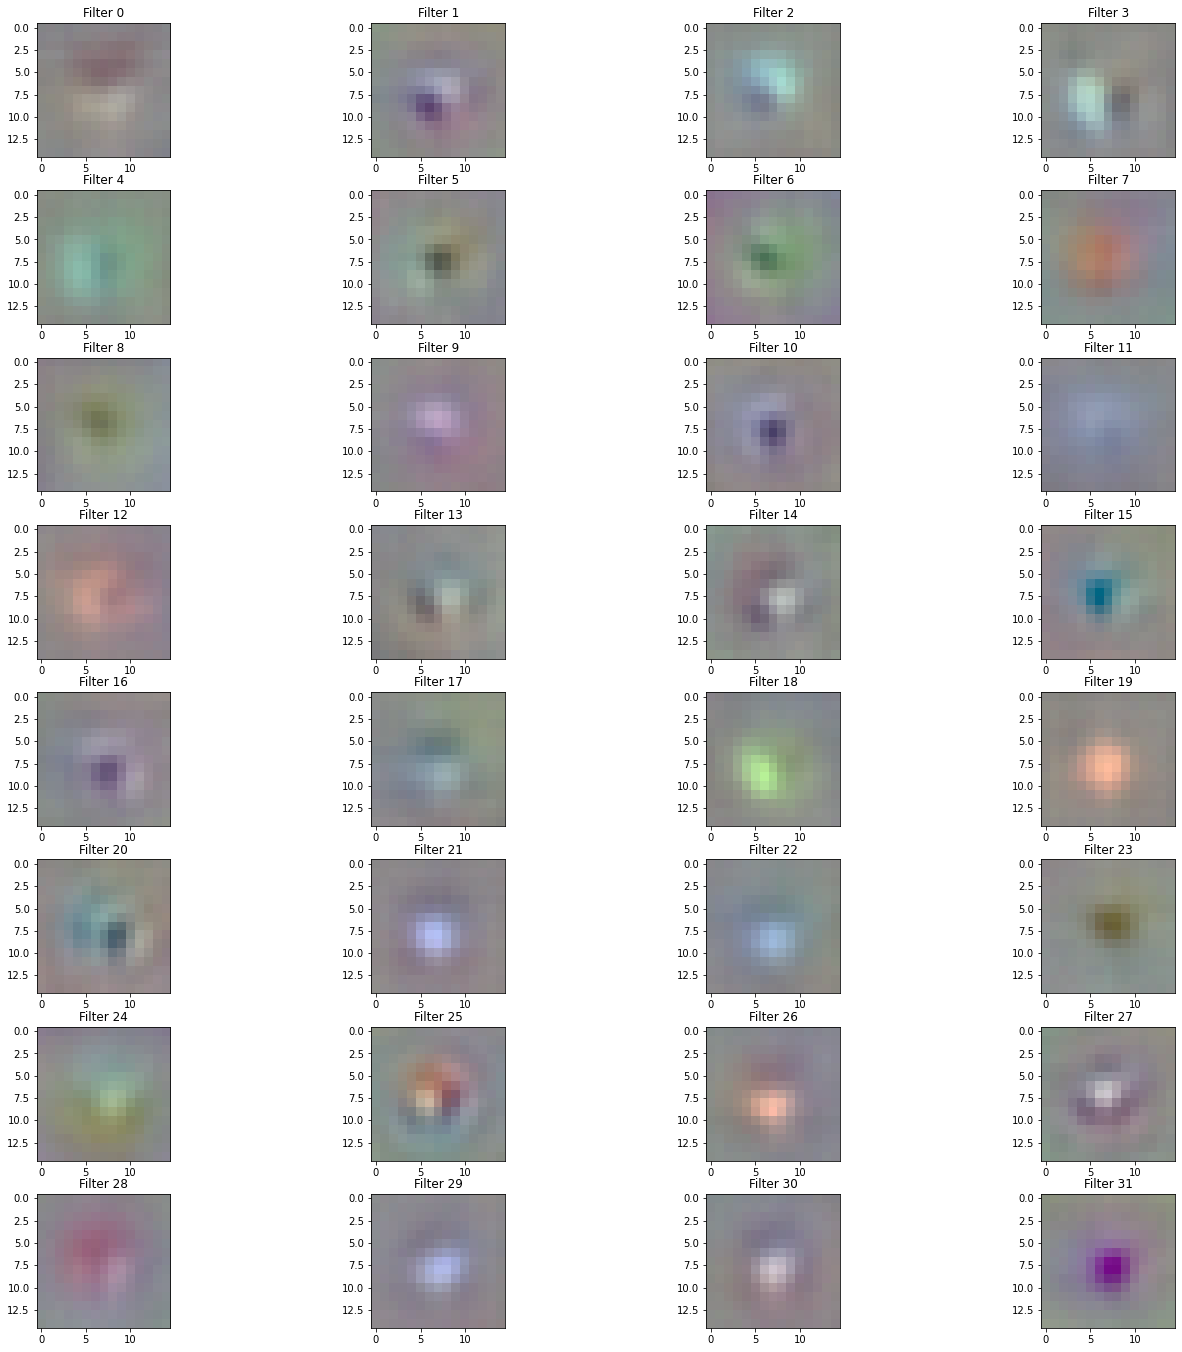

In [21]:
from sklearn.preprocessing import MinMaxScaler

cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape

# this part will scale to [0, 1] for visualization purposes
scaler = MinMaxScaler()
scaler.fit(W.reshape(-1,1))
W = scaler.transform(W.reshape(-1,1))
W = W.reshape(wshape)

fig, axs = plt.subplots(8,NUM_RECEPTIVE_FILTERS//8, figsize=(24,24))
fig.subplots_adjust(hspace = .25, wspace=.001)
axs = axs.ravel()
for i in range(W.shape[-1]):
  # we reshape to a 3D (RGB) image shape and display
  h = np.reshape(W[:,:,:,i], (GABOR_WIDTH,GABOR_HEIGHT,3))
  axs[i].imshow(h)
  axs[i].set_title('Filter ' + str(i))    
plt.savefig("caltech256-{}-filters-kernel-{}.png".format(ITERATION,GABOR_WIDTH), bbox_inches='tight', dpi=350)

-2.0441146 1.7182391


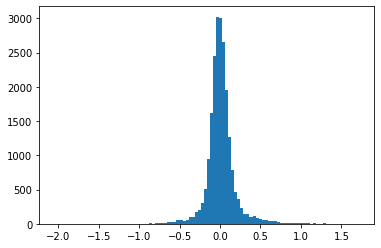

In [22]:
cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]
plt.hist(W.ravel(), bins=100)
print(np.min(W),np.max(W))

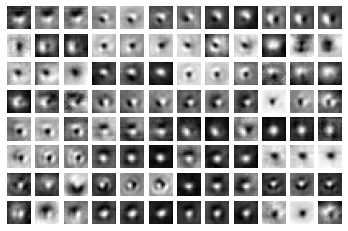

In [23]:
filter_layers = []
for i in range(NUM_RECEPTIVE_FILTERS):
    for j in range(3):
        filter_layers.append(np.reshape(W[:,:,j, i], GABOR_SIZE))
for i,gf in enumerate(filter_layers):
    plt.subplot(8, (W.shape[3]*3)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')
plt.savefig("caltech256-{}-channelwise-filters-kernel-{}.png".format(ITERATION,GABOR_WIDTH), bbox_inches='tight', dpi=350)

In [24]:
!cp caltech256-2-history-kernel-15.p /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-128-final/2/

In [25]:
!cp caltech256-2-loss-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-128-final/2/

In [26]:
!cp caltech256-2-accuracy-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-128-final/2/

In [27]:
!cp caltech256-2-filters-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-128-final/2/

In [28]:
!cp caltech256-2-channelwise-filters-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-128-final/2/